# Movement similarity

In [399]:
import os
import copy
import math
import pickle
import random
from datetime import datetime

from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, SpectralClustering

In [406]:
sns.set_theme()
sns.set_context("paper")

In [9]:
proj_dir = "..."
rev_dir = "..."

## Read trajectories and precomputed distances

### Trajectories and tracking pts

In [17]:
# read trajectory and background sample (simulated) pts pickle
pk_name = "trajpts_simpts_mid_migr_lat_30N.pickle"
with open(os.path.join(rev_dir, pk_name), 'rb') as my_file_obj:
    pts_df, traj_ptid_ls, traj_len_km, sim_pts_df = pickle.load(my_file_obj)

n_trajs = len(traj_ptid_ls)

print(f"Number of points: {pts_df.shape[0]}")
print(f"Number of trajectories: {n_trajs}")

Number of points: 17118
Number of trajectories: 62


In [364]:
pts_df.head()

,OID_,event_id,timestamp,location_long,location_lat,ground_speed,heading,height_raw,raptor_workshop_migration_state,individual_taxon_canonical_name,tag_local_identifier,individual_local_identifier,study_name,study_timezone,study_local_timestamp,utm_x,utm_y,local_stamp,TrajID,Movebank Thermal Uplift (from ECMWF),ECMWF Interim Full Daily SFC Temperature (2 m above Ground),MODIS Land Vegetation Indices 250m 16d Aqua NDVI,Movebank Orographic Uplift (from ASTER DEM and ECMWF),ECMWF ERA5 SL Wind (10 m above Ground U Component),ECMWF ERA5 SL Wind (10 m above Ground V Component),ECMWF ERA5 SL Total Precipitation,Tailwind,Crosswind,migr_state
0,1,2216138,00:00.0,-105.1315,51.069833,0.0000,270.000,NaN,FallMigration,Cathartes aura,57952,Sill,Turkey Vulture Acopian Center USA GPS,Pacific Daylight Time,10/1/2005 0:00:00,-348609.4876,5727950.41,1128150000,0,0.0,280.56110,0.279038,0.0,0.349709,0.123803,0.000000e+00,0.349709,0.123803,Fall
1,2,2216139,00:00.0,-105.1315,51.069833,0.0000,270.000,NaN,FallMigration,Cathartes aura,57952,Sill,Turkey Vulture Acopian Center USA GPS,Pacific Daylight Time,10/1/2005 1:00:00,-348609.4876,5727950.41,1128153600,0,0.0,280.63522,0.278976,0.0,-0.795907,0.199403,0.000000e+00,-0.795907,0.199403,Fall
2,3,2216140,00:00.0,-105.1315,51.069833,0.0000,270.000,NaN,FallMigration,Cathartes aura,57952,Sill,Turkey Vulture Acopian Center USA GPS,Pacific Daylight Time,10/1/2005 2:00:00,-348609.4876,5727950.41,1128157200,0,0.0,280.70934,0.278914,0.0,-1.347227,0.548029,0.000000e+00,-1.347227,0.548029,Fall
3,4,2216141,00:00.0,-105.1315,51.069833,0.0000,270.000,NaN,FallMigration,Cathartes aura,57952,Sill,Turkey Vulture Acopian Center USA GPS,Pacific Daylight Time,10/1/2005 3:00:00,-348609.4876,5727950.41,1128160800,0,0.0,280.78346,0.278851,0.0,-1.740786,1.327150,3.615100e-07,-1.740786,1.327150,Fall
4,5,2216142,00:00.0,-105.1315,51.069833,0.0061,41.711,NaN,FallMigration,Cathartes aura,57952,Sill,Turkey Vulture Acopian Center USA GPS,Pacific Daylight Time,10/1/2005 4:00:00,-348609.4876,5727950.41,1128164400,0,0.0,280.85758,0.278789,0.0,-1.673733,2.109677,3.281825e-05,2.688554,-2.653183,Fall


In [368]:
fall_traj_ptid_ls = []
spring_traj_ptid_ls = []

for tji in tqdm(traj_ptid_ls):
    if pts_df.loc[tji[1][0], 'migr_state'] == 'Fall':
        fall_traj_ptid_ls.append(tji)
    else:
        spring_traj_ptid_ls.append(tji)
        
print("Number of fall trajectories:", len(fall_traj_ptid_ls))
print("Number of spring trajectories:", len(spring_traj_ptid_ls))

100%|██████████| 62/62 [00:00<00:00, 62122.99it/s]

Number of fall trajectories: 37
Number of spring trajectories: 25


In [372]:
# interval
intervals = []
for traji in fall_traj_ptid_ls:
    for pti in traji[1][1:]:
        intervals.append(pts_df.loc[pti, 'local_stamp']
                         - pts_df.loc[pti-1, 'local_stamp'])
        
mean_intvl = round(np.mean(intervals)/3600, 3)
std_intvl = np.std(intervals) / 3600

print("Fall interval mean:", mean_intvl, "h")
print("Fall interval standard deviation:", std_intvl, "h")

intervals = []
for traji in spring_traj_ptid_ls:
    for pti in traji[1][1:]:
        intervals.append(pts_df.loc[pti, 'local_stamp']
                         - pts_df.loc[pti-1, 'local_stamp'])
        
mean_intvl = round(np.mean(intervals)/3600, 3)
std_intvl = np.std(intervals) / 3600

print("Spring interval mean:", mean_intvl, "h")
print("Spring interval standard deviation:", std_intvl, "h")

Fall interval mean: 1.507 h
Fall interval standard deviation: 4.30152682910774 h
Spring interval mean: 1.725 h
Spring interval standard deviation: 6.746373394660874 h


In [373]:
# speed
fall_ptids = []
for tji in fall_traj_ptid_ls:
    fall_ptids.extend(tji[1])
spring_ptids = []
for tji in spring_traj_ptid_ls:
    spring_ptids.extend(tji[1])

fall_pts_df = pts_df.loc[fall_ptids]
spring_pts_df = pts_df.loc[spring_ptids]

spd_mean = np.mean(fall_pts_df['ground_speed'].to_numpy())
spd_std = np.std(fall_pts_df['ground_speed'].to_numpy())

print("Fall speed mean:", spd_mean*3.6, "km/h")
print("Fall speed standard deviation:", spd_std*3.6, "km/h")

spd_mean = np.mean(spring_pts_df['ground_speed'].to_numpy())
spd_std = np.std(spring_pts_df['ground_speed'].to_numpy())

print("Fall speed mean:", spd_mean*3.6, "km/h")
print("Fall speed standard deviation:", spd_std*3.6, "km/h")

Fall speed mean: 6.497473920275309 km/h
Fall speed standard deviation: 14.523514828563039 km/h
Fall speed mean: 8.572793943217667 km/h
Fall speed standard deviation: 16.720852888521968 km/h


In [376]:
# trajectory length
fall_trajids = []
for tji in fall_traj_ptid_ls:
    fall_trajids.append(tji[0])
spring_trajids = []
for tji in spring_traj_ptid_ls:
    spring_trajids.append(tji[0])
    
fall_lengths = [traj_len_km[i] for i in fall_trajids]
len_mean = np.mean(fall_lengths)
len_std = np.std(fall_lengths)
print("Fall length mean:", len_mean, "km")
print("Fall speed standard deviation:", len_std, "km")

spring_lengths = [traj_len_km[i] for i in spring_trajids]
len_mean = np.mean(spring_lengths)
len_std = np.std(spring_lengths)
print("Spring length mean:", len_mean, "km")
print("Spring speed standard deviation:", len_std, "km")

Fall length mean: 2291.5177297297296 km
Fall speed standard deviation: 739.2857002433534 km
Spring length mean: 2834.5422 km
Spring speed standard deviation: 715.9871631102893 km


In [377]:
# tracking time span per trajectory
time_span_sec = []
time_span_day = []
for tji in fall_traj_ptid_ls:
    time_span_sec.append(pts_df.loc[tji[1][-1], 'local_stamp']
                         - pts_df.loc[tji[1][0], 'local_stamp'])
for tji in time_span_sec:
    time_span_day.append(round(tji / (3600*24), 2))

print("Fall time span mean:", np.mean(time_span_day), "days")
print("Fall time span std:", np.std(time_span_day), "days")

time_span_sec = []
time_span_day = []
for tji in spring_traj_ptid_ls:
    time_span_sec.append(pts_df.loc[tji[1][-1], 'local_stamp']
                         - pts_df.loc[tji[1][0], 'local_stamp'])
for tji in time_span_sec:
    time_span_day.append(round(tji / (3600*24), 2))

print("Spring time span mean:", np.mean(time_span_day), "days")
print("Spring time span std:", np.std(time_span_day), "days")

Fall time span mean: 17.685135135135134 days
Fall time span std: 7.301177106734274 days
Spring time span mean: 19.0668 days
Spring time span std: 7.4621657553286775 days


In [380]:
# tracking time span of the whole dataset
local_timestamp = pts_df.loc[:, 'local_stamp'].to_list()
min_local_timestamp = min(local_timestamp)
max_local_timestamp = max(local_timestamp)
time_span_sec_dataset = max_local_timestamp - min_local_timestamp
time_span_day_dataset = round(time_span_sec_dataset / (3600*24), 2)

bird_names = []
for tji in traj_ptid_ls:
    if pts_df.loc[tji[1][0], 'individual_local_identifier'] not in bird_names:
        bird_names.append(pts_df.loc[tji[1][0], 'individual_local_identifier'])
n_birds = len(bird_names)

# tracking time span per individual bird
initial_min_local_timestamp = np.array([max_local_timestamp for birdi in bird_names])
initial_max_local_timestamp = np.array([min_local_timestamp for birdi in bird_names])
bird_time_span_df = pd.DataFrame(
    {
        'name': bird_names, 'min_local_timestamp': initial_min_local_timestamp,
        'max_local_timestamp': initial_max_local_timestamp
    }
)

for pti in range(len(pts_df)):
    bird_index = bird_names.index(pts_df.loc[pti, 'individual_local_identifier'])
    timestamp = pts_df.loc[pti, 'local_stamp']
    if timestamp < bird_time_span_df.loc[bird_index, 'min_local_timestamp']:
        bird_time_span_df.loc[bird_index, 'min_local_timestamp'] = timestamp
    if timestamp > bird_time_span_df.loc[bird_index, 'max_local_timestamp']:
        bird_time_span_df.loc[bird_index, 'max_local_timestamp'] = timestamp

for birdi in range(len(bird_time_span_df)):
    bird_time_span_df.loc[birdi, 'time_span_sec'] = (
        bird_time_span_df.loc[birdi, 'max_local_timestamp'] 
        - bird_time_span_df.loc[birdi, 'min_local_timestamp'])
    bird_time_span_df.loc[birdi, 'time_span_day'] = (
        bird_time_span_df.loc[birdi, 'time_span_sec'] / (3600*24))

for birdi in range(len(bird_time_span_df)):
    start_dt_object = datetime.fromtimestamp(bird_time_span_df.loc[birdi, 'min_local_timestamp'])
    bird_time_span_df.loc[birdi, 'start_date'] = start_dt_object.strftime('%m/%d/%Y')
    end_dt_object = datetime.fromtimestamp(bird_time_span_df.loc[birdi, 'max_local_timestamp'])
    bird_time_span_df.loc[birdi, 'end_date'] = end_dt_object.strftime('%m/%d/%Y')

# record datetime of each tracking point for each bird
bird_dt_list = [[] for birdi in range(len(bird_time_span_df))]
for pti in range(len(pts_df)):
    bird_idx = bird_names.index(pts_df.loc[pti, 'individual_local_identifier'])
    dt_object = datetime.fromtimestamp(pts_df.loc[pti, 'local_stamp'])
    date_object = dt_object.date()
    # dt_string = dt_object.strftime('%m/%d/%Y')
    if date_object not in bird_dt_list[bird_idx]:
        bird_dt_list[bird_idx].append(date_object)

In [403]:
bird_names

['Sill',
 'Blizzard',
 'Duck Lake',
 'Ranger',
 'Mac',
 'Leo',
 'Steamhouse 1',
 'Steamhouse 2',
 'David',
 'Ricky',
 'Harriet',
 'Ozzie',
 'Tommy']

In [404]:
colors = [
    (188/255, 128/255, 189/255), (141/255, 211/255, 199/255),
    (190/255, 186/255, 218/255), (252/255, 205/255, 229/255),
    (253/255, 180/255, 98/255), (128/255, 177/255, 211/255),
    (204/255, 235/255, 197/255), (255/255, 237/255, 111/255),
    (255/255, 255/255, 179/255), (217/255, 217/255, 217/255),
    (251/255, 128/255, 114/255), (179/255, 222/255, 105/255),
    (230/255, 152/255, 0),
]
print("Number of colors:", len(colors))

Number of colors: 13


In [402]:
colors = list(matplotlib.cm.get_cmap("Set3").colors)
colors.extend(
    [
        (230/255, 152/255, 0), (178/255, 178/255, 178/255)
    ]
)

print("Number of colors:", len(colors))

Number of colors: 14


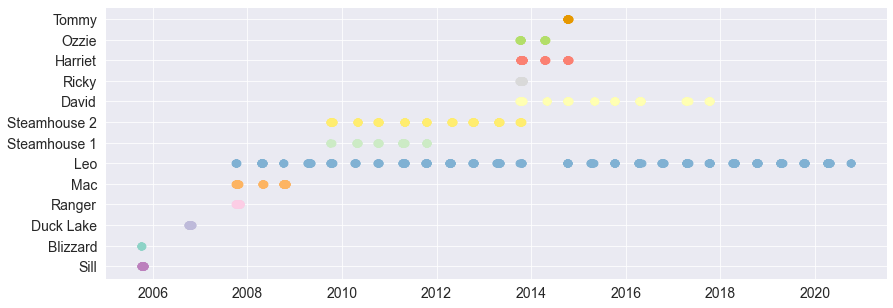

In [418]:
# sns.set_theme(style="whitegrid")

matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

plt.figure(figsize=(14,5))
for birdi in range(len(bird_names)):
    birdi_name = bird_names[birdi]
    y = []
    for birdi_dt in bird_dt_list[birdi]:
        y.append(birdi_name)
    plt.scatter(bird_dt_list[birdi], y, color=colors[birdi], s=50)    

plt.savefig(os.path.join(rev_dir, "time_span.eps"), format='eps')

### Distances

In [12]:
# read precomputaed distances
pk_name = "precomputed_dist_arr_mid_migr_lat_30N.pickle"
with open(os.path.join(rev_dir, pk_name), 'rb') as my_file_obj:
    frechet_dist_arr, dtw_dist_arr, hausdorff_dist_arr, lcss_dist_arr, nwed_dist_arr = pickle.load(my_file_obj)

print(f"Shape of dist_arr: {frechet_dist_arr.shape}")

Shape of dist_arr: (62, 62)


In [133]:
# normalize distances
scaler = MinMaxScaler()
norm_frechet_dist_arr = scaler.fit_transform(
    frechet_dist_arr.reshape(-1, 1)
).reshape(n_trajs, n_trajs)

scaler = MinMaxScaler()
norm_dtw_dist_arr = scaler.fit_transform(
    dtw_dist_arr.reshape(-1, 1)
).reshape(n_trajs, n_trajs)

scaler = MinMaxScaler()
norm_hausdorff_dist_arr = scaler.fit_transform(
    hausdorff_dist_arr.reshape(-1, 1)
).reshape(n_trajs, n_trajs)

scaler = MinMaxScaler()
norm_lcss_dist_arr = scaler.fit_transform(
    lcss_dist_arr.reshape(-1, 1)
).reshape(n_trajs, n_trajs)

scaler = MinMaxScaler()
norm_nwed_dist_arr = scaler.fit_transform(
    nwed_dist_arr.reshape(-1, 1)
).reshape(n_trajs, n_trajs)

In [157]:
norm_dist_dict = {
    'frechet': norm_frechet_dist_arr, 'dtw': norm_dtw_dist_arr, 'hausdorff': norm_hausdorff_dist_arr,
    'lcss': norm_lcss_dist_arr, 'nwed': norm_nwed_dist_arr
}

## Environmental variables

In [359]:
sim_pts_df.head()

,PtID,location-long,location-lat,timestamp,Migr_state,Movebank Thermal Uplift (from ECMWF),ECMWF Interim Full Daily SFC Temperature (2 m above Ground),MODIS Land Vegetation Indices 250m 16d Aqua NDVI,Movebank Orographic Uplift (from ASTER DEM and ECMWF),ECMWF ERA5 SL Wind (10 m above Ground U Component),ECMWF ERA5 SL Wind (10 m above Ground V Component),ECMWF ERA5 SL Total Precipitation,heading,Tailwind,Crosswind
0,0,-92.543645,45.817708,2014-10-07 20:00:00.000,Fall,1.416826,284.053177,0.648622,0.435182,6.000811,-3.027958,0.000000,336.381,-0.370063,4.284963
1,1,-98.669637,35.453309,2014-04-12 13:00:00.000,Spring,0.356296,291.149421,0.307842,0.197500,0.102582,5.988670,0.000000,89.170,-0.015821,-5.986555
2,2,-108.070890,33.709794,2011-10-02 23:00:00.000,Fall,0.445020,290.285689,0.481772,0.000000,1.128377,0.796169,0.001757,184.773,-0.699518,-1.058216
3,3,-107.692878,50.227538,2016-04-22 05:00:00.000,Spring,0.001711,283.486043,0.222441,0.045331,-5.699878,2.701274,0.000000,272.889,-5.556486,2.410560
4,4,-97.314462,48.341835,2009-10-06 13:00:00.000,Fall,0.229358,278.043128,0.244735,0.165786,0.780178,-3.487409,0.000089,0.885,-3.499044,0.833950


In [360]:
env_vars = sim_pts_df.columns.to_list()[5:12] + sim_pts_df.columns.to_list()[13:]
env_vars

['Movebank Thermal Uplift (from ECMWF)',
 'ECMWF Interim Full Daily SFC Temperature (2 m above Ground)',
 'MODIS Land Vegetation Indices 250m 16d Aqua NDVI',
 'Movebank Orographic Uplift (from ASTER DEM and ECMWF)',
 'ECMWF ERA5 SL Wind (10 m above Ground U Component)',
 'ECMWF ERA5 SL Wind (10 m above Ground V Component)',
 'ECMWF ERA5 SL Total Precipitation',
 'Tailwind',
 'Crosswind']

Test the correlation between environmental variables.

In [362]:
env_pts_df = sim_pts_df[env_vars]
env_pts_df.head()

,Movebank Thermal Uplift (from ECMWF),ECMWF Interim Full Daily SFC Temperature (2 m above Ground),MODIS Land Vegetation Indices 250m 16d Aqua NDVI,Movebank Orographic Uplift (from ASTER DEM and ECMWF),ECMWF ERA5 SL Wind (10 m above Ground U Component),ECMWF ERA5 SL Wind (10 m above Ground V Component),ECMWF ERA5 SL Total Precipitation,Tailwind,Crosswind
0,1.416826,284.053177,0.648622,0.435182,6.000811,-3.027958,0.000000,-0.370063,4.284963
1,0.356296,291.149421,0.307842,0.197500,0.102582,5.988670,0.000000,-0.015821,-5.986555
2,0.445020,290.285689,0.481772,0.000000,1.128377,0.796169,0.001757,-0.699518,-1.058216
3,0.001711,283.486043,0.222441,0.045331,-5.699878,2.701274,0.000000,-5.556486,2.410560
4,0.229358,278.043128,0.244735,0.165786,0.780178,-3.487409,0.000089,-3.499044,0.833950


In [363]:
env_pts_df.corr()

,Movebank Thermal Uplift (from ECMWF),ECMWF Interim Full Daily SFC Temperature (2 m above Ground),MODIS Land Vegetation Indices 250m 16d Aqua NDVI,Movebank Orographic Uplift (from ASTER DEM and ECMWF),ECMWF ERA5 SL Wind (10 m above Ground U Component),ECMWF ERA5 SL Wind (10 m above Ground V Component),ECMWF ERA5 SL Total Precipitation,Tailwind,Crosswind
Movebank Thermal Uplift (from ECMWF),1.000000,0.277533,-0.061507,0.074661,0.164041,-0.032376,-0.067350,0.017390,-0.016879
ECMWF Interim Full Daily SFC Temperature (2 m above Ground),0.277533,1.000000,0.269874,0.001900,-0.025944,0.334214,0.022525,-0.021721,0.059017
MODIS Land Vegetation Indices 250m 16d Aqua NDVI,-0.061507,0.269874,1.000000,-0.015048,-0.064990,0.038114,0.086592,-0.007969,0.013551
Movebank Orographic Uplift (from ASTER DEM and ECMWF),0.074661,0.001900,-0.015048,1.000000,0.068577,-0.031735,0.021813,-0.009828,-0.006209
ECMWF ERA5 SL Wind (10 m above Ground U Component),0.164041,-0.025944,-0.064990,0.068577,1.000000,-0.176871,-0.084908,0.144013,-0.078331
ECMWF ERA5 SL Wind (10 m above Ground V Component),-0.032376,0.334214,0.038114,-0.031735,-0.176871,1.000000,-0.065215,-0.059114,0.175704
ECMWF ERA5 SL Total Precipitation,-0.067350,0.022525,0.086592,0.021813,-0.084908,-0.065215,1.000000,-0.010361,0.002715
Tailwind,0.017390,-0.021721,-0.007969,-0.009828,0.144013,-0.059114,-0.010361,1.000000,-0.090222
Crosswind,-0.016879,0.059017,0.013551,-0.006209,-0.078331,0.175704,0.002715,-0.090222,1.000000


## Hierarical clustering

### Spectral clustering

Damle, A., Minden, V., & Ying, L. (2019). Simple, direct and efficient multi-way spectral clustering. Information and Inference: A Journal of the IMA, 8(1), 181-203.

#### Initial clustering

In [192]:
def traj_clustering(metric, n_clu_lowbd, n_clu_highbd):
    '''
    Cluster trajectories using different metrics.

    Parameters
    ----------
    metric : 'string'
    n_clu_lowbd : int
    n_clu_highbd : int

    Returns
    -------
    labels_df: pd.DataFrame

    '''
    n_cols = n_clu_highbd - n_clu_lowbd + 1
    
    # distance matrix
    norm_dist_arr = norm_dist_dict[metric]
    
    # clustering
    labels = np.zeros((n_trajs, n_cols)).astype(int)
    count = 0
    n_clu_list = []
    for n_clusters in range(n_clu_lowbd, n_clu_highbd+1):
        cluster = SpectralClustering(n_clusters=n_clusters, affinity='precomputed').fit(1-norm_dist_arr)
        labels[:, count] = cluster.labels_
        count += 1
        n_clu_list.append(metric + '_' + str(n_clusters))
    
    # output
    labels_df = pd.DataFrame(data=labels, columns=n_clu_list)
    # add 'TrajID' column
    traj_id = list(range(n_trajs))
    labels_df['Traj_ID'] = traj_id
    # rearrange column order
    cols = labels_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    labels_df = labels_df[cols]
    
    return labels_df

In [193]:
frechet_initclus_df = traj_clustering(metric='frechet', n_clu_lowbd=2, n_clu_highbd=9)
initclus_df = copy.deepcopy(frechet_initclus_df)
# dtw
labels_df = traj_clustering(metric='dtw', n_clu_lowbd=2, n_clu_highbd=9)
initclus_df = initclus_df.merge(labels_df, on='Traj_ID')
# hausdorff
labels_df = traj_clustering(metric='hausdorff', n_clu_lowbd=2, n_clu_highbd=9)
initclus_df = initclus_df.merge(labels_df, on='Traj_ID')
# lcss
labels_df = traj_clustering(metric='lcss', n_clu_lowbd=2, n_clu_highbd=9)
initclus_df = initclus_df.merge(labels_df, on='Traj_ID')
# nwed
labels_df = traj_clustering(metric='nwed', n_clu_lowbd=2, n_clu_highbd=9)
initclus_df = initclus_df.merge(labels_df, on='Traj_ID')

In [194]:
def annotate_initclus(initclus_df):
    tags = []
    names = []
    migr_status = []
    fall_begin = datetime(month=10, day=1, year=2000).strftime('%m/%d')
    fall_end = datetime(month=12, day=5, year=2000).strftime('%m/%d')
    spring_begin = datetime(month=3, day=15, year=2000).strftime('%m/%d')
    spring_end = datetime(month=5, day=5, year=2000).strftime('%m/%d')
    for tji in range(initclus_df.shape[0]):
        pti = traj_ptid_ls[tji][1][0]

        tags.append(pts_df.loc[pti, 'tag_local_identifier'])
        names.append(pts_df.loc[pti, 'individual_local_identifier'])

        pti_dt = pts_df.loc[pti, 'study_local_timestamp']
        pti_date = datetime.strptime(pti_dt, '%m/%d/%Y %H:%M:%S').strftime('%m/%d')
        if fall_begin <= pti_date <= fall_end:
            migr_status.append('Fall')
        elif spring_begin <= pti_date <= spring_end:
            migr_status.append('Spring')

    # add columns to initclus_df
    initclus_df['tag'] = tags
    initclus_df['name'] = names
    initclus_df['migr_status'] = migr_status
    # rearrange column order
    cols = initclus_df.columns.tolist()
    cols = cols[-3:] + cols[:-3]
    initclus_df = initclus_df[cols]
    
    return initclus_df

In [196]:
initclus_anno_df = annotate_initclus(initclus_df)

In [197]:
def reorder_clu_id(labels, n_clusters):
    '''
    Reorder the cluster IDs so that the order of the cluster IDs is in the order of
    the number of trajectories it contains.
        e.g. 
        cluster ID 0: most
        cluster ID 1: second most
        ...
        cluster ID n: least

    Parameters
    ----------
    labels : np.array
        labels of clusters
    n_clusters : int
        number of clusters

    Returns
    -------
    re_labels : np.array
        labels reordered

    '''
    n_rows = len(labels)
    
    # count the cluster ids
    contrast = np.zeros((n_clusters, 3))
    contrast_df = pd.DataFrame(contrast, columns=['clu_id', 'count', 'reordered'])
    contrast_df.loc[:, 'clu_id'] = list(range(n_clusters))
    for rowi in range(n_rows):
        clu_id = labels[rowi]
        contrast_df.loc[clu_id, 'count'] = contrast_df.loc[clu_id, 'count'] + 1
    
    # sort by count
    contrast_df = contrast_df.sort_values(by=['count'], ascending=False)
    contrast_df.loc[:, 'reordered'] = list(range(n_clusters))
    
    # output
    re_labels = np.zeros(n_rows)
    for rowi in range(n_rows):
        clu_id_original = labels[rowi]
        clu_id_reordered = contrast_df.loc[clu_id_original, 'reordered']
        re_labels[rowi] = clu_id_reordered
    
    re_labels = re_labels.astype('int')
    return re_labels

def reorder_cluster_df(cluster_df, cols):
    '''
    Reorder a cluster_df

    Parameters
    ----------
    cluster_df : pd.DataFrame
        cluster IDs (and other descriptive information)
    cols : list
        column numbers (of cluster IDs) that need to be reordered
        e.g., [3, 10]

    Returns
    -------
    re_cluster_df : pd.DataFrame
        cluster_df reordered 

    '''
    col_names = cluster_df.columns.tolist()
    
    # output
    re_cluster_df = copy.deepcopy(cluster_df)
    
    # reorder each column
    for coli in cols:
        # labels (np.array)
        labels = cluster_df.iloc[:, coli].to_numpy()
        
        # number of clusters
        col_name = col_names[coli]
        n_clu_index = col_name.find('_') + 1
        n_clusters = int(col_name[n_clu_index:])
        
        # reorder the column
        re_labels = reorder_clu_id(labels, n_clusters)
        re_cluster_df.iloc[:, coli] = re_labels
    
    return re_cluster_df

In [198]:
cols = list(range(4, initclus_anno_df.shape[1]))
initclus_anno_df = reorder_cluster_df(initclus_anno_df, cols)

pd.set_option('display.max_rows', None, 'display.max_columns', None)
initclus_anno_df

,tag,name,migr_status,Traj_ID,frechet_2,frechet_3,frechet_4,frechet_5,frechet_6,frechet_7,frechet_8,frechet_9,dtw_2,dtw_3,dtw_4,dtw_5,dtw_6,dtw_7,dtw_8,dtw_9,hausdorff_2,hausdorff_3,hausdorff_4,hausdorff_5,hausdorff_6,hausdorff_7,hausdorff_8,hausdorff_9,lcss_2,lcss_3,lcss_4,lcss_5,lcss_6,lcss_7,lcss_8,lcss_9,nwed_2,nwed_3,nwed_4,nwed_5,nwed_6,nwed_7,nwed_8,nwed_9
0,57952,Sill,Fall,0,0,0,0,2,1,3,4,1,0,0,0,2,3,2,1,0,0,0,0,1,2,2,1,3,0,0,0,1,0,1,1,0,0,2,2,3,3,2,4,2
1,57953,Blizzard,Fall,1,0,0,3,4,5,6,7,7,1,0,3,4,4,0,6,7,1,2,2,4,4,6,6,8,0,2,3,4,5,6,7,8,1,0,0,1,1,1,5,5
2,57953,Duck Lake,Fall,2,0,0,3,4,5,6,7,7,0,0,3,4,5,6,7,8,1,2,3,3,5,5,7,7,0,2,3,4,5,6,7,8,0,2,2,3,3,2,2,2
3,65543,Ranger,Fall,3,0,0,0,1,1,1,5,6,0,0,0,1,2,3,5,2,0,0,0,1,1,1,0,0,0,0,2,2,2,0,3,3,0,2,2,3,3,4,4,2
4,65544,Mac,Fall,4,0,0,0,1,2,1,1,3,0,0,0,1,2,3,5,2,0,0,0,1,1,3,3,2,0,0,0,2,2,0,2,6,0,2,2,3,3,2,4,2
5,65544,Mac,Spring,5,1,2,2,3,4,5,6,5,1,2,2,0,0,5,3,6,1,1,1,2,2,2,2,4,1,1,1,0,1,5,6,1,0,0,0,1,1,1,0,0
6,65544,Mac,Fall,6,0,2,2,2,3,4,3,1,0,2,2,3,0,2,2,0,1,1,1,2,2,2,2,4,0,0,0,1,2,0,3,3,0,2,2,3,3,2,0,2
7,65545,Leo,Fall,7,0,2,2,2,3,4,3,1,0,2,2,3,0,0,2,0,1,1,1,2,2,2,2,4,0,0,0,2,2,0,3,3,0,0,0,0,1,1,0,1
8,65545,Leo,Spring,8,1,1,1,0,0,0,0,0,1,1,1,0,1,1,0,1,0,0,0,0,0,1,0,0,1,1,1,0,1,3,0,2,0,2,2,3,3,2,2,4
9,65545,Leo,Fall,9,0,2,2,2,3,4,3,8,0,2,2,3,0,0,2,3,1,1,1,2,3,4,5,6,0,0,0,3,1,5,3,3,1,0,0,1,1,1,5,5


In [199]:
# save as csv
csv_name = "SpecClus_2-9_Mid_Migr_Lat30N_TV.csv"
initclus_anno_df.to_csv(
    os.path.join(rev_dir, csv_name)
)

In [187]:
def metric_silh(metric, n_clu_lowbd, n_clu_highbd, cluster_df):
    '''
    Compute the Silhouette Coefficient of the initial clustering result.

    Parameters
    ----------
    metric : str
        Name of the metric, e.g., 'frechet'.
    n_clu_lowbd : int
        The lower bound of the number of clusters, e.g., 2.
    n_clu_highbd : int
        The upper bound of the number of clusters, e.g., 9.
    cluster_df : pd.DataFrame, optional
        The dataframe storing the clustering results. The default is cluster_df.

    Returns
    -------
    silh : float
        Computed Silhouette Coefficient.
    '''
    # distance matrix
    norm_dist_arr = norm_dist_dict[metric]
    
    # read labels 
    n_clu = []
    for n_clui in range(n_clu_lowbd, n_clu_highbd+1):
        n_clu.append(metric + '_' + str(n_clui))
    labels = cluster_df.loc[:, n_clu]
    
    # compute sc
    silh = []
    for n_clui in range(labels.shape[1]):
        silh.append(metrics.silhouette_score(norm_dist_arr, labels.iloc[:, n_clui], 
                                                 metric='precomputed'))
    
    return silh

In [200]:
n_clu_lowbd = 2
n_clu_highbd = 9
fre_silh = metric_silh('frechet', n_clu_lowbd, n_clu_highbd, initclus_anno_df)
dtw_silh = metric_silh('dtw', n_clu_lowbd, n_clu_highbd, initclus_anno_df)
hausdorff_silh = metric_silh('hausdorff', n_clu_lowbd, n_clu_highbd, initclus_anno_df)
lcss_silh = metric_silh('lcss', n_clu_lowbd, n_clu_highbd, initclus_anno_df)
nwed_silh = metric_silh('nwed', n_clu_lowbd, n_clu_highbd, initclus_anno_df)

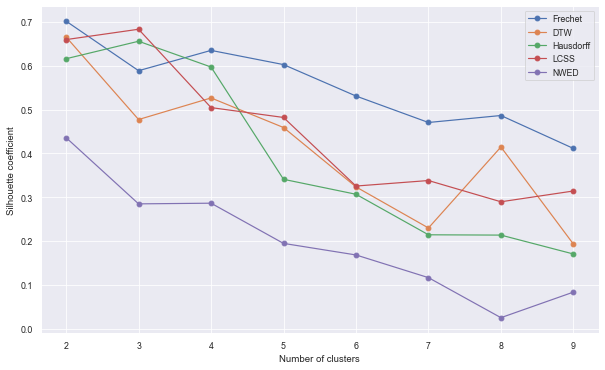

In [202]:
# plot sc of initial clustering results
x = list(range(n_clu_lowbd, n_clu_highbd+1))  # numbder of clusters
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x, fre_silh, 'o-', label='Frechet')
ax.plot(x, dtw_silh, 'o-', label='DTW')
ax.plot(x, hausdorff_silh, 'o-', label='Hausdorff')
ax.plot(x, lcss_silh, 'o-', label='LCSS')
ax.plot(x, nwed_silh, 'o-', label='NWED')

ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette coefficient')
plt.legend(loc='best')
# plt.title('Silhouette coefficient of initial clustering results')
plt.show()

In [286]:
def metric_compare(metric, n_clusters, cluster_df):
    # find the corresponding trajectories
    labels = cluster_df.loc[:, metric].to_numpy()
    label_trajs = []
    for clui in range(n_clusters):
        traj_index = np.where(labels == clui)[0]
        label_trajs.append(traj_index)
    
    avg_n_pts = []  # average number of pts in a trajectory
    avg_len_km = []  # average trajectory lengths in kilometers
    fall_count = []  # fall migration count
    spring_count = []  # spring migration count
    avg_start_time = []  # average start time (local)
    avg_end_time = []  # average end time (local)
    
    df_indexes = []  # indexes in the output pd.DataFrame
    
    for clui in range(n_clusters):
        n_trajs = len(label_trajs[clui])  # number of trajectories in the cluster
        
        n_pts = []
        traj_len = []
        
        # if it is a fall migration trajectory, +1
        # if spring, +0
        fall_sum = 0
        
        start_timestamps = []
        end_timestamps = []
        
        for tji in label_trajs[clui]:
            # number of points
            n_pts.append(traj_ptid_ls[tji][2]) 
            traj_len.append(traj_len_km[tji])
            # migration status
            if cluster_df.loc[tji, 'migr_status'] == 'Fall':
                fall_sum += 1
            # start and end time
            start_pt = traj_ptid_ls[tji][1][0]
            end_pt = traj_ptid_ls[tji][1][-1]
            
            real_start_time = datetime.strptime(pts_df.loc[start_pt, 'study_local_timestamp'],
                                                '%m/%d/%Y %H:%M:%S')
            # year should not be considered
            start_time = real_start_time.replace(year=2000)
            start_time = datetime.timestamp(start_time)
            
            real_end_time = datetime.strptime(pts_df.loc[end_pt, 'study_local_timestamp'],
                                                '%m/%d/%Y %H:%M:%S')
            # year should not be considered
            end_time = real_end_time.replace(year=2000)
            end_time = datetime.timestamp(end_time)
            
            start_timestamps.append(start_time)
            end_timestamps.append(end_time)
        
        avg_n_pts.append(round(np.mean(n_pts)))  # average number of points
        avg_len_km.append(round(np.mean(traj_len), 3))  # average trajectory lengths in kilometers
        fall_count.append(fall_sum)  # fall migration count
        spring_count.append(n_trajs - fall_sum)  # spring migration count
        avg_start_timestamp = int(np.mean(start_timestamps))
        avg_end_timestamp = int(np.mean(end_timestamps))
        # average start time
        avg_start_time.append(datetime.fromtimestamp(avg_start_timestamp).strftime("%m/%d %H:%M:%S"))
        # average end time
        avg_end_time.append(datetime.fromtimestamp(avg_end_timestamp).strftime("%m/%d %H:%M:%S"))
        
        df_indexes.append(metric + '_' + str(clui))   
    
        new_df = pd.DataFrame(list(zip(avg_n_pts, avg_len_km, fall_count, spring_count,
                                         avg_start_time, avg_end_time)),
                                         columns = ['avg_n_pts', 'avg_len_km', 'fall_count',
                                                    'spring_count', 'avg_start_time',
                                                    'avg_end_time'],
                                         index=df_indexes)

    return new_df

In [288]:
# frechet_2
metric = 'frechet_2'
optimal_metric_compare_df = metric_compare(metric, n_clusters=2, cluster_df=initclus_anno_df)
# dtw_2
metric = 'dtw_2'
new_df = metric_compare(metric, n_clusters=2, cluster_df=initclus_anno_df)
optimal_metric_compare_df = optimal_metric_compare_df.append(new_df)
# hausdorff_3
metric = 'hausdorff_3'
new_df = metric_compare(metric, n_clusters=3, cluster_df=initclus_anno_df)
optimal_metric_compare_df = optimal_metric_compare_df.append(new_df)
# lcss_3
metric = 'lcss_3'
new_df = metric_compare(metric, n_clusters=3, cluster_df=initclus_anno_df)
optimal_metric_compare_df = optimal_metric_compare_df.append(new_df)
# nwed_2
metric = 'nwed_2'
new_df = metric_compare(metric, n_clusters=2, cluster_df=initclus_anno_df)
optimal_metric_compare_df = optimal_metric_compare_df.append(new_df)

In [289]:
optimal_metric_compare_df

,avg_n_pts,avg_len_km,fall_count,spring_count,avg_start_time,avg_end_time
frechet_2_0,283,2291.518,37,0,10/01 17:59:35,10/19 10:25:58
frechet_2_1,266,2834.542,0,25,04/12 10:26:26,05/01 12:02:33
dtw_2_0,287,2350.801,36,0,10/01 18:26:15,10/19 18:48:21
dtw_2_1,261,2731.572,1,25,04/19 00:53:06,05/07 14:14:00
hausdorff_3_0,298,2915.357,24,21,07/12 03:23:41,08/01 13:20:05
hausdorff_3_1,200,1577.187,11,4,08/20 11:28:00,09/01 09:52:04
hausdorff_3_2,358,400.418,2,0,10/01 01:00:00,10/17 17:30:00
lcss_3_0,278,2399.581,35,0,10/01 18:57:51,10/19 12:46:18
lcss_3_1,266,2834.542,0,25,04/12 10:26:26,05/01 12:02:33
lcss_3_2,358,400.418,2,0,10/01 01:00:00,10/17 17:30:00


#### Hierarchical clustering

Use the silhouette coefficient as the stopping criterion 

In [224]:
def initialClui(metric, n_clusters, clui, cluster_df):
    # initial cluster clui
    clusters = []
    for ci in range(n_clusters):
        traj_index = cluster_df[metric + '_' + str(n_clusters)] == ci
        clu_trajs = cluster_df.loc[traj_index, 'Traj_ID'].to_list()
        clu_n_trajs = len(clu_trajs)
        clusters.append([metric + '_' + str(clui), 'n_trajs=' + str(clu_n_trajs), clu_trajs])
    
    clui_trajs = clusters[clui][2]
    
    df_idx = []
    current_trajs = cluster_df.loc[:, 'Traj_ID'].to_list()
    for ci in clui_trajs:
        df_idx.append(current_trajs.index(ci))
    
    clui_df = cluster_df.loc[df_idx, ['tag', 'name', 'migr_status', 'Traj_ID', 
                                         metric + '_' + str(n_clusters)]].reset_index(
                                             drop=True)
    clui_df.rename(columns={metric + '_' + str(n_clusters): metric + '-' + str(n_clusters)}, inplace=True)

    # add manual labels for later comparison
    # label 0-n_tv based on the frequency
    tags = clui_df['tag'].to_list()
    tags_sorted = sorted(tags, key = tags.count, reverse = True)
    tags_unique = []
    for tagi in tags_sorted:
        if tagi not in tags_unique:
            tags_unique.append(tagi)
    for count, tagi in enumerate(tags_unique):
        clui_df.loc[clui_df['tag'] == tagi, 'tag_label'] =  count
    
    # change column type
    clui_df = clui_df.astype({'tag_label':'int'})
    
    return clusters, clui_trajs, clui_df

def zoomInNCluster(metric, n_clusters, clui, cluster_df):
    '''
    Zoom in cluster
    perform clustering again based on the results of initial clustering
    
    Parameters
    ---------
    metric : str
        metric of initial clustering, e.g., 'frechet'
    n_clusters : int
        number of initial clusters 
    clui : int
        cluster id, e.g., 0
    cluster_df : pd.DataFrame
        clustering results

    Returns
    -------
    cluster_2nd_df : pd.DataFrame
        clustering results based on 5 different metrics

    '''
    clusters, clui_trajs, clui_df = initialClui(metric, n_clusters, clui, cluster_df)
    
    # further clustering
    # frechet, dtw, hausdorff, lcss, nwed
    # n_clusters: 2-9
    n_start = 2
    
    # check clu_n_trajs
    clu_n_trajs = len(clui_trajs)
    if clu_n_trajs > 9:
        n_end = 9
    else:
        n_end = clu_n_trajs - 1
    n_clu_col = 5 * (n_end - n_start + 1)
    
    labels = np.zeros((len(clui_trajs), n_clu_col)).astype(int)
    dist_metrics = ['frechet', 'dtw', 'hausdorff', 'lcss', 'nwed']
    n_clu_list = []  # column names
    count = 0
    
    for meti in dist_metrics:
        # distance matrix
        norm_dist_arr = norm_dist_dict[metric]
        
        # new dist_arr contains only trajectories in clui_df
        clui_trajs = clusters[clui][2]
        clui_dist_arr = norm_dist_arr[clui_trajs, :][:, clui_trajs]
        
        for sec_n_clu in range(n_start, n_end+1):
            # column names
            n_clu_list.append(meti + '_' + str(sec_n_clu))
            
            cluster = SpectralClustering(n_clusters=sec_n_clu, affinity='precomputed').fit(1-clui_dist_arr)
            labels[:, count] = cluster.labels_
            count += 1
    
    # output pd.DataFrame
    further_cluster_df = pd.DataFrame(data=labels, columns=n_clu_list)
    # add tag, name, migr_status, TrajID to cluster_2nd_df
    further_cluster_df = clui_df.join(further_cluster_df)
    
    return further_cluster_df

def cmptSilhouette(cluster_df, clui):
    start_col = 6  # start with the 6th column  
    col_names = cluster_df.columns.tolist()
    
    sc_list = []
    for coli in range(start_col, cluster_df.shape[1]):     
        # (2nd) metric and n_clusters
        col_name = col_names[coli]
        index_ = col_name.index('_')
        metric_2nd = col_name[:index_]
        n_clusters_2nd = int(col_name[(index_+1):])
        
        # distance matrix
        norm_dist_arr = norm_dist_dict[metric_2nd]
        # new dist_arr contains only trajectories in clui_df
        clui_trajs = cluster_df.loc[:, 'Traj_ID'].to_list()
        clui_dist_arr = norm_dist_arr[clui_trajs, :][:, clui_trajs]
    
        # compute silhouette score
        labels = cluster_df.iloc[:, coli]
        sc = metrics.silhouette_score(clui_dist_arr, labels, metric='precomputed')
        sc_list.append(sc)
    
    # arrange the silhouette score list
    sc_list_arranged = []
    dist_metrics = ['frechet', 'dtw', 'hausdorff', 'lcss', 'nwed']
    # number of clusters tried
    n_metrics = 5
    n_clu_trials = int((cluster_df.shape[1] - start_col) / n_metrics)
    for meti in range(len(dist_metrics)):
        new_list = [dist_metrics[meti], sc_list[meti*n_clu_trials:(meti+1)*n_clu_trials]]
        sc_list_arranged.append(new_list)
    
    return sc_list_arranged

def bestSCZoomInCluster(metric, init_n_clu, clui, cluster_df):
    # zoom-in clustering
    data_df = zoomInNCluster(metric=metric, n_clusters=init_n_clu, clui=clui, 
                             cluster_df=cluster_df)
    data_reorder_df = reorder_cluster_df(data_df, list(range(6, data_df.shape[1])))
    
    # compute silhouette coefficient
    sc = cmptSilhouette(data_reorder_df, clui=clui)
    
    # find the metric with the highest silhouette coefficient
    metric_highest_sc = []
    for meti in sc:
        metric_highest_sc.append(max(meti[1]))
    high_mt_idx = metric_highest_sc.index(max(metric_highest_sc))
    if high_mt_idx == 0:
        high_metric = 'frechet'
    elif high_mt_idx == 1:
        high_metric = 'dtw'
    elif high_mt_idx == 2:
        high_metric = 'hausdorff'
    elif high_mt_idx == 3:
        high_metric = 'lcss'
    elif high_mt_idx == 4:
        high_metric = 'nwed'
    # n_clusters starts with 2
    high_n_clu = sc[high_mt_idx][1].index(metric_highest_sc[high_mt_idx]) + 2
    
    # clustering results that have the highest silhouette coefficient
    col_names = data_reorder_df.columns.to_list()[:6]
    mt_highest_sc_str = high_metric + '_' + str(high_n_clu)
    col_names.append(mt_highest_sc_str)
    high_sc_df = data_reorder_df.loc[:, col_names]
    
    # highest silhouette
    highest_sc = max(metric_highest_sc)
    
    return high_sc_df, mt_highest_sc_str, highest_sc

In [337]:
def recurCluster_SC(current_cluster_df):
    # parameters for zoom-in clustering
    prev_mt_highest_sc = current_cluster_df.columns.to_list()[6]
    index_ = prev_mt_highest_sc.index('_')
    metric = prev_mt_highest_sc[:index_]
    init_n_clu = int(prev_mt_highest_sc[(index_+1):])
    clui = current_cluster_df.loc[0, prev_mt_highest_sc]
    
    # zoom-in clustering
    high_sc_df, mt_highest_sc, highest_sc = bestSCZoomInCluster(metric, init_n_clu, 
                                                       clui, current_cluster_df)
    index_ = mt_highest_sc.index('_')
    high_n_clu = int(mt_highest_sc[(index_+1):])
    
    # update output_list
    output_list_update = []
    for ci in range(high_n_clu):
        output_list_update.append(high_sc_df.loc[high_sc_df[mt_highest_sc] == ci]
                                  .reset_index(drop=True))
    
    return output_list_update, highest_sc, mt_highest_sc


def hrchyCluster_SC(sc_th, dist_met, init_n_clu, clui, current_cluster_df):
    # silhouette records for each step of clustering
    sc_records = []
    # metric records
    met_records = []
    
    # zoom-in clustering
    high_sc_df, mt_highest_sc, highest_sc = bestSCZoomInCluster(dist_met, 
                                                                    init_n_clu, 
                                                                    clui, current_cluster_df)
    index_ = mt_highest_sc.index('_')
    high_n_clu = int(mt_highest_sc[(index_+1):])
    sc_records.append(highest_sc)
    met_records.append(mt_highest_sc)
    
    # output
    output_records = []
    output_list = []
    for ci in range(high_n_clu):
        output_list.append(high_sc_df.loc[high_sc_df[mt_highest_sc] == ci]
                           .reset_index(drop=True))
    hrchyi_list = []  # clusters of trajectories at that hierarchy
    for li in output_list:
        hrchyi_list.append(li.loc[:, 'Traj_ID'].to_list())
    output_records.append(hrchyi_list)
    
    clus_count = 0
    
    # check the highest SC
    # to decide whether to continue zoom-in clustering
    global_highest_sc = highest_sc
    while global_highest_sc > sc_th:
        clus_count += 1
        
        global_highest_sc= -1  # the highest silh at that hierarchy
        
        new_hrchyi_sc_records = []
        new_hrchyi_met_records = []
        
        # output list will change later
        orig_output_list = copy.deepcopy(output_list)
        # check whether the cluster needs further clustering
        updated_output_list = []
        for clui_id, clui_trajs in enumerate(hrchyi_list):
            if len(clui_trajs) <= 2:
                updated_output_list.append(output_list[clui_id])
                continue
            
            current_cluster_df = orig_output_list[clui_id]
            # zoom-in clustering
            output_list_update, highest_sc, mt_highest_sc = recurCluster_SC(current_cluster_df)
            
            # check whether this further clustering makes sense
            if highest_sc >= sc_th:  # clustering makes sense
                # update output_list
                updated_output_list.extend(output_list_update)
                
                # record silh and met
                new_hrchyi_sc_records.append(highest_sc)
                new_hrchyi_met_records.append(mt_highest_sc)
            
            else: 
                updated_output_list.append(output_list[clui_id])
        
            # update the global_highest_sc
            if highest_sc > global_highest_sc:
                global_highest_sc = highest_sc
        
        output_list = copy.deepcopy(updated_output_list)
        
        # chech whether the new hierarchy needs to be recorded
        if global_highest_sc >= sc_th:  
            # record trajs at that hierarchy
            new_hrchyi_list = []
            for li in output_list:
                new_hrchyi_list.append(li.loc[:, 'Traj_ID'].to_list())
            output_records.append(new_hrchyi_list)
        
            # record silh and met at that hierarchy
            sc_records.append(new_hrchyi_sc_records)
            met_records.append(new_hrchyi_met_records)
        
            # update the hierarchy list to begin the next iteration
            hrchyi_list = copy.deepcopy(new_hrchyi_list)
    
    return output_records, sc_records, met_records

In [330]:
def plotHrchyCluter_SC(hrchy_results, fig_title):
    plt.figure(figsize=(16,6))
    x = [str(item) for sublist in hrchy_results[-1] for item in sublist]
    plt.plot(x, [0 for item in x], color=(0,0,0,0))  # transparent

    clus = []  # store the clusters
    for count, hrchyi in enumerate(hrchy_results):
        ci_y = len(hrchy_results) - count - 1
        for ci in hrchyi:
            if len(ci) == 1:  # only 1 trajectory
                plt.vlines(str(ci[0]), ci_y, ci_y+1, color='blue')
                clus.append(ci)
            else:
                # find the index in the string list
                x_idx = np.zeros((len(ci), 2)).astype(int)
                x_idx[:, 0] = ci
                for rowi in range(len(x_idx)):
                    x_idx[rowi, 1] = x.index(str(x_idx[rowi, 0]))
                x_idx_sort = x_idx[np.argsort(x_idx[:, 1])]

                plt.vlines(str(x_idx_sort[0, 0]), ci_y, ci_y+1, color='blue')
                plt.vlines(str(x_idx_sort[-1, 0]), ci_y, ci_y+1, color='blue')

                if ci not in clus:
                    ci_x = [str(item) for item in ci]
                    ci_y_list = [ci_y+1 for item in ci]
                    plt.plot(ci_x, ci_y_list, color='blue')
                    clus.append(ci)
    
    # the overarching cluster
    plt.vlines(x[0], len(hrchy_results), len(hrchy_results)+1, color='blue')
    plt.vlines(x[-1], len(hrchy_results), len(hrchy_results)+1, color='blue')
    plt.plot(x, [len(hrchy_results)+1 for item in x], color='blue')
    

    yticks = range(len(hrchy_results)+2)
    plt.yticks(yticks, yticks[::-1])
    plt.xlabel('Trajectory ID')
    plt.ylabel('Hierarchy')
    plt.title(fig_title)

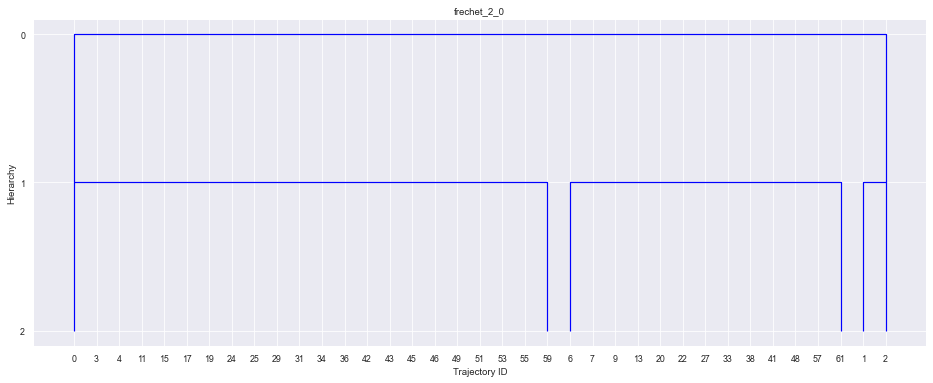

In [351]:
frechet_2_0_hrchy, frechet_2_0_hrchy_sc, frechet_2_0_hrchy_met = hrchyCluster_SC(
    sc_th=0.5, dist_met='frechet', init_n_clu=2, clui=0, current_cluster_df=initclus_anno_df
)

plotHrchyCluter_SC(frechet_2_0_hrchy, 'frechet_2_0')
plt.savefig(os.path.join(rev_dir, "frechet_2_0.eps"), format='eps')

In [356]:
print("frechet_2_0_hrchy_sc", frechet_2_0_hrchy_sc)
print("frechet_2_0_hrchy_met", frechet_2_0_hrchy_met)

frechet_2_0_hrchy_sc [0.5762006021606746]
frechet_2_0_hrchy_met ['frechet_3']


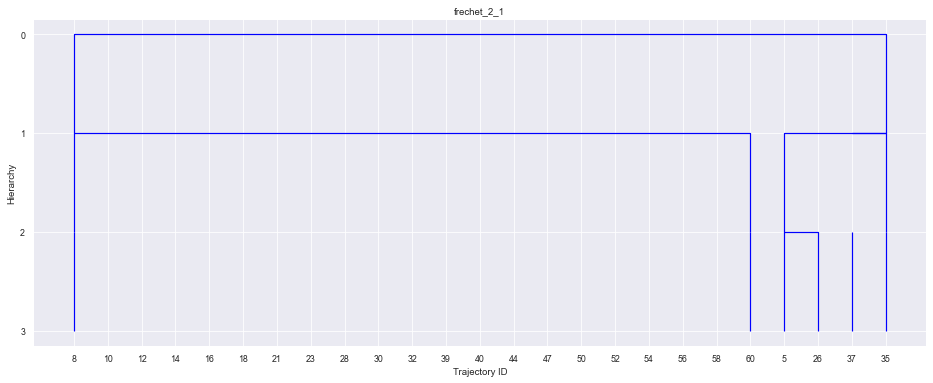

In [357]:
frechet_2_1_hrchy, frechet_2_1_hrchy_sc, frechet_2_1_hrchy_met = hrchyCluster_SC(
    sc_th=0.5, dist_met='frechet', init_n_clu=2, clui=1, current_cluster_df=initclus_anno_df
)

plotHrchyCluter_SC(frechet_2_1_hrchy, 'frechet_2_1')
plt.savefig(os.path.join(rev_dir, "frechet_2_1.eps"), format='eps')

In [355]:
print("frechet_2_1_hrchy_sc", frechet_2_1_hrchy_sc)
print("frechet_2_1_hrchy_met", frechet_2_1_hrchy_met)

frechet_2_1_hrchy_sc [0.7727076799815877, [0.5]]
frechet_2_1_hrchy_met ['hausdorff_2', ['lcss_3']]


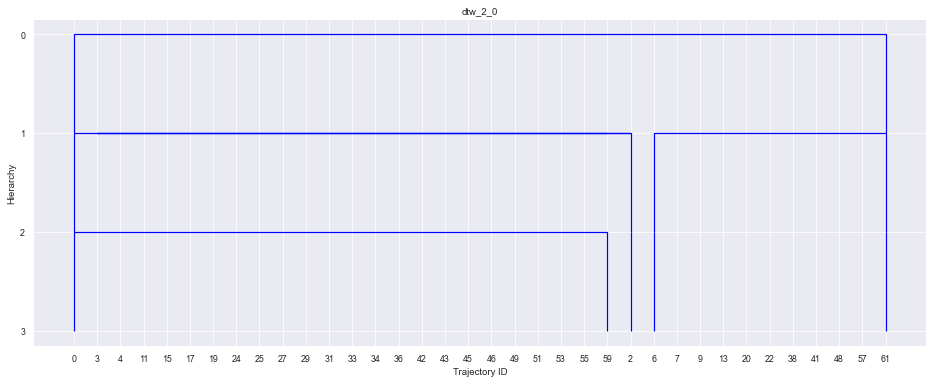

In [340]:
dtw_2_0_hrchy, dtw_2_0_hrchy_sc, dtw_2_0_hrchy_met = hrchyCluster_SC(
    sc_th=0.5, dist_met='dtw', init_n_clu=2, clui=0, current_cluster_df=initclus_anno_df
)

plotHrchyCluter_SC(dtw_2_0_hrchy, 'dtw_2_0')

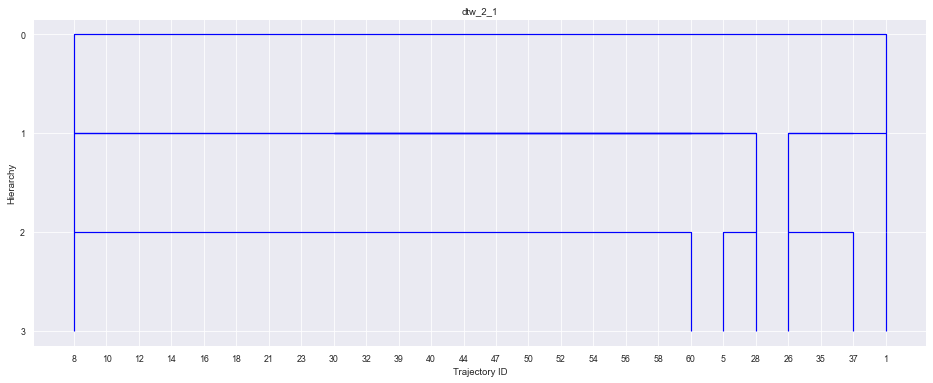

In [341]:
dtw_2_1_hrchy, dtw_2_1_hrchy_sc, dtw_2_1_hrchy_met = hrchyCluster_SC(
    sc_th=0.5, dist_met='dtw', init_n_clu=2, clui=1, current_cluster_df=initclus_anno_df
)

plotHrchyCluter_SC(dtw_2_1_hrchy, 'dtw_2_1')

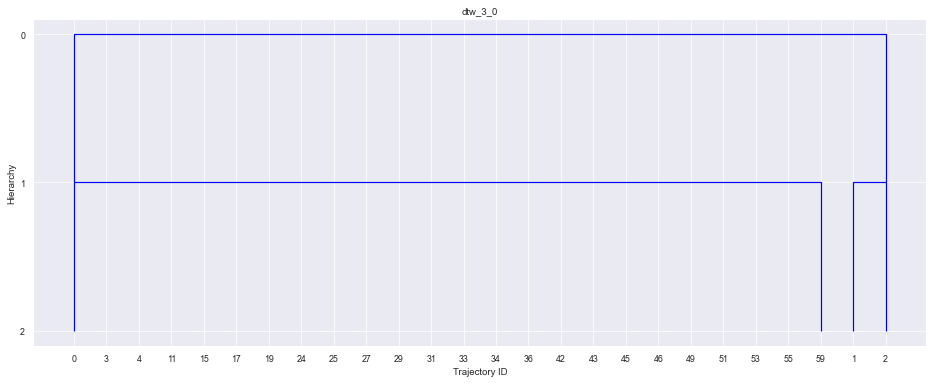

In [344]:
dtw_3_0_hrchy, dtw_3_0_hrchy_sc, dtw_3_0_hrchy_met = hrchyCluster_SC(
    sc_th=0.5, dist_met='dtw', init_n_clu=3, clui=0, current_cluster_df=initclus_anno_df
)

plotHrchyCluter_SC(dtw_3_0_hrchy, 'dtw_3_0')

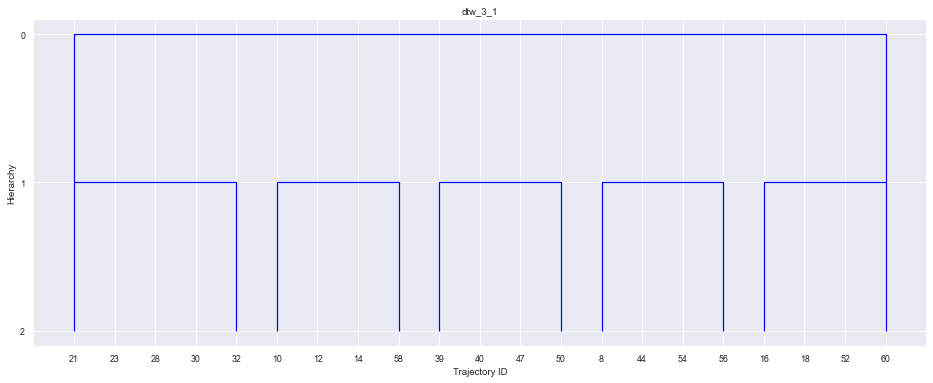

In [345]:
dtw_3_1_hrchy, dtw_3_1_hrchy_sc, dtw_3_1_hrchy_met = hrchyCluster_SC(
    sc_th=0.5, dist_met='dtw', init_n_clu=3, clui=1, current_cluster_df=initclus_anno_df
)

plotHrchyCluter_SC(dtw_3_1_hrchy, 'dtw_3_1')

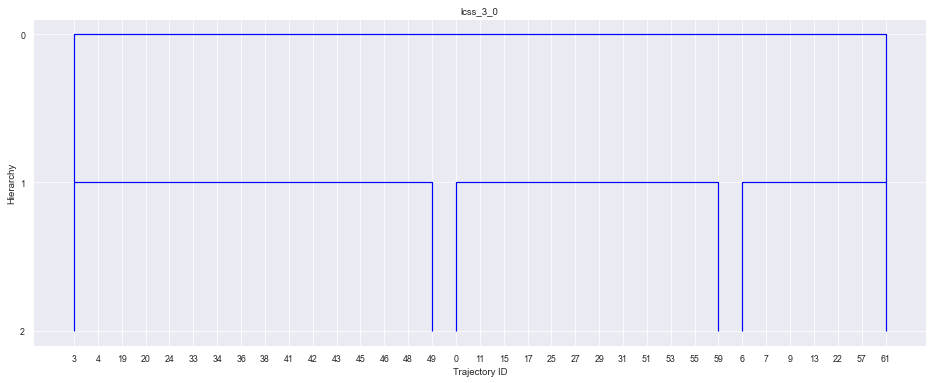

In [342]:
lcss_3_0_hrchy, lcss_3_0_hrchy_sc, lcss_3_0_hrchy_met = hrchyCluster_SC(
    sc_th=0.5, dist_met='lcss', init_n_clu=3, clui=0, current_cluster_df=initclus_anno_df
)

plotHrchyCluter_SC(lcss_3_0_hrchy, 'lcss_3_0')

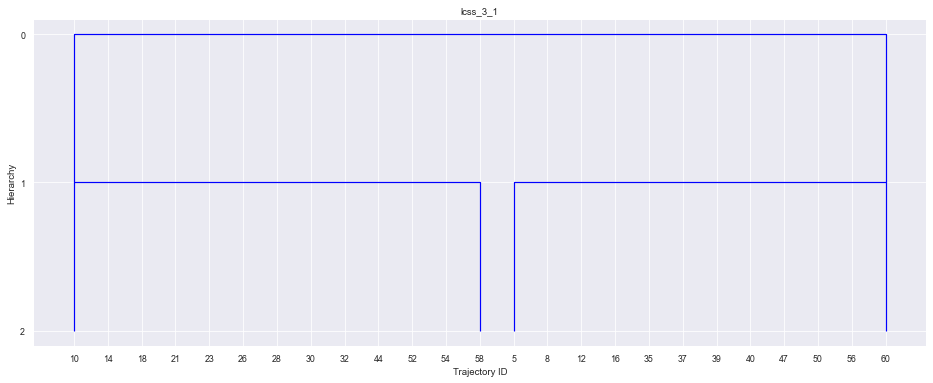

In [343]:
lcss_3_1_hrchy, lcss_3_1_hrchy_sc, lcss_3_1_hrchy_met = hrchyCluster_SC(
    sc_th=0.5, dist_met='lcss', init_n_clu=3, clui=1, current_cluster_df=initclus_anno_df
)

plotHrchyCluter_SC(lcss_3_1_hrchy, 'lcss_3_1')